#PanColorization GAN

Colab Notebook for Pansharpening Demo with PanColorization GAN

Ozcelik, F., Alganci, U., Sertel, E., & Unal, G. (2020). Rethinking CNN-Based Pansharpening: Guided Colorization of Panchromatic Images via GANs. arXiv preprint arXiv:2006.16644. Arxiv Link

In [1]:
!git clone https://github.com/ozcelikfu/PanColorGAN.git
!cp PanColorGAN/*.py ./
!gdown --id 1F4iCyeC_5OXWada3UW780YgXx-63GQno --output PanColorGANRD.pth

Cloning into 'PanColorGAN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 165 (delta 94), reused 147 (delta 82), pack-reused 0
Receiving objects: 100% (165/165), 6.19 MiB | 20.86 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Downloading...
From: https://drive.google.com/uc?id=1F4iCyeC_5OXWada3UW780YgXx-63GQno
To: /content/PanColorGANRD.pth
32.7MB [00:00, 70.5MB/s]


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from networks import define_G
from util import patch_sixteen, divide_sixteen, show_image, scale_range
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#@title #**Upload MS and PAN Images** { display-mode: "form" }
from google.colab import files
import tifffile

!rm -rf raw_images/
!mkdir raw_images/
#@markdown *Run this code to be offered to upload a photo from the computer. Upload both images*

dropdown = 'Upload Images' #@param ["Default Images", "Upload Images"]
if dropdown == "Upload Images":
  uploaded = files.upload()
  keys=[]
  for fp in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fp, length=len(uploaded[fp])))
    keys.append(fp)
  if len(uploaded[keys[0]])>len(uploaded[keys[1]]):
    pan_fn, ms_fn = keys[0], keys[1]
  else:
    pan_fn, ms_fn = keys[1], keys[0]
    
  ms = tifffile.imread(ms_fn)
  pan = tifffile.imread(pan_fn)
  print(ms.shape,pan.shape)
  ms = ms.astype(np.float32)
  pan = pan.astype(np.float32)

elif dropdown == "Default Images":
  ms_filename = '/content/PanColorGAN/data/dg_msimage200.npy'
  pan_filename = '/content/PanColorGAN/data/dg_panimage200.npy'
  ms = np.load(ms_filename).astype(np.float32)
  pan = np.load(pan_filename).astype(np.float32)
  print(ms.shape,pan.shape)

Saving new6_5_50_pan.tif to new6_5_50_pan.tif
Saving new6_5_50_xs.tif to new6_5_50_xs.tif
User uploaded file "new6_5_50_pan.tif" with length 2099560 bytes
User uploaded file "new6_5_50_xs.tif" with length 525194 bytes
(256, 256, 4) (1024, 1024)


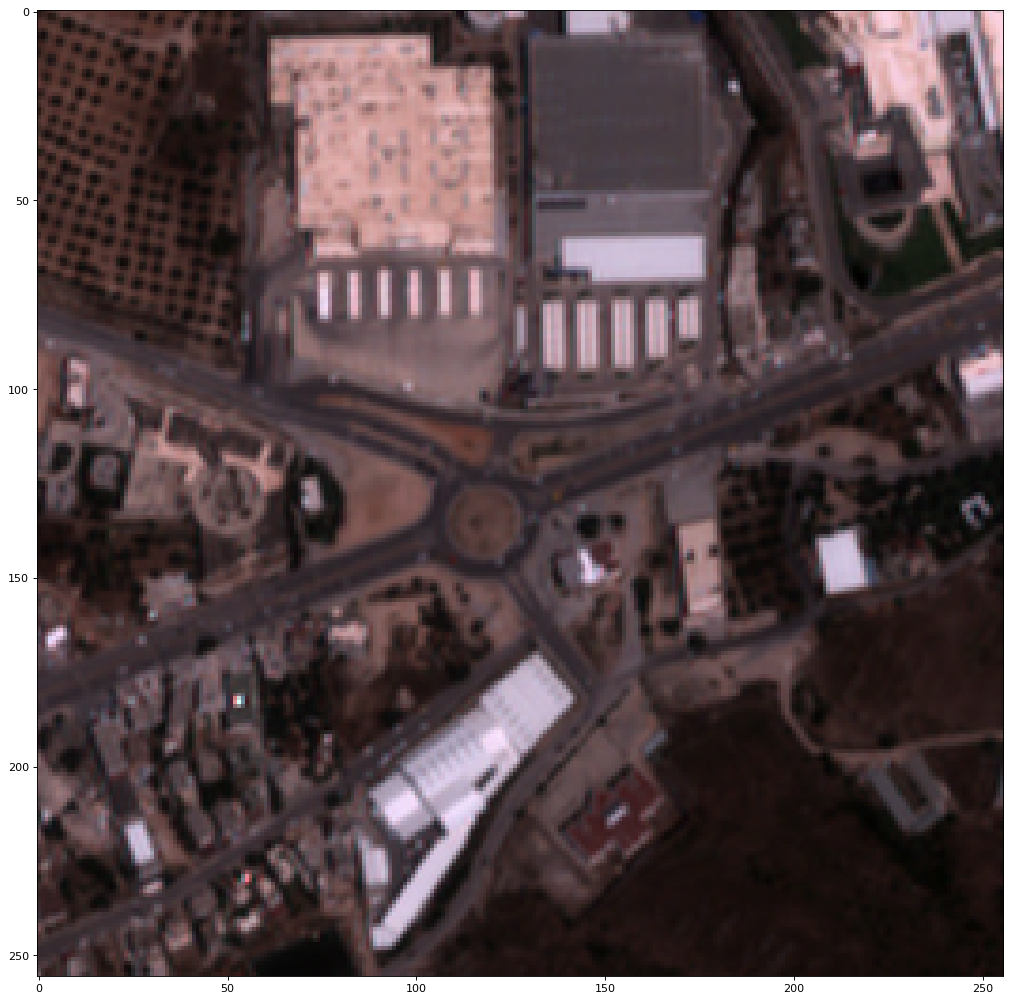

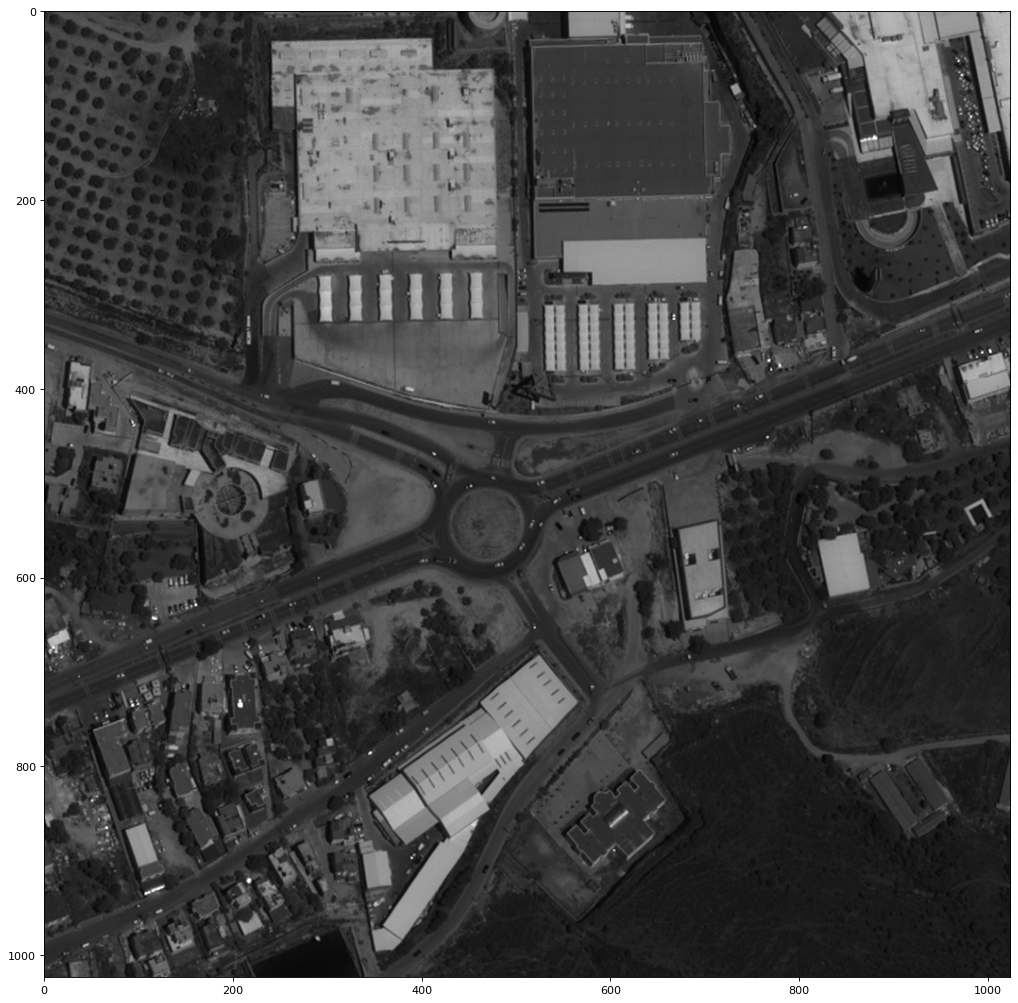

In [4]:
## Data Display

show_image(ms)
show_image(pan)

In [5]:
## Parameters
#@title Parameters { display-mode: "form" }
reduced_res=False #@param {type:"boolean"}
use_gpu=True #@param {type:"boolean"}

In [6]:
## Data Preprocessing
from skimage.transform import resize
ms_norm = np.array([scale_range(i, -1, 1) for i in ms.transpose((2,0,1))])
pan_norm = scale_range(pan, -1, 1)

if reduced_res:
  ms_down = [resize(i,(64,64), 3) for i in ms_norm]
  ms_up = [resize(i, (256, 256), 3) for i in ms_down]
  ms_norm = np.clip(ms_up,-1.0,1.0)
  pan_down = resize(pan_norm, (256, 256), 3)
  pan_norm = np.clip(pan_down,-1.0,1.0)
else: 
  ms_up = [resize(i, (1024, 1024), 3) for i in ms_norm]
  ms_norm = np.clip(ms_up,-1.0,1.0)

inp = np.concatenate((ms_norm,np.expand_dims(pan_norm,axis=0)),axis=0)
if not reduced_res:
  inp = divide_sixteen(inp)
inp = torch.tensor(inp)

In [7]:
## Network Preparation
model_weights = "/content/PanColorGANRD.pth"
netG = define_G(5, 4, 32, 'batch','leakyrelu', False, 'ResizeConv', 'colorunet', 'SE', 6, [0], n_downsampling=2)
#netG.load_state_dict(torch.load(model_weights, map_location=lambda storage, loc: storage))
netG.load_state_dict(torch.load(model_weights))
netG.eval()
if use_gpu:
  netG = netG.cuda()
else:
  netG = netG.cpu()

In [8]:
if use_gpu:
  out = netG(inp.cuda().view(-1,5,256,256)).detach().cpu().numpy()
else:
  out = netG(inp.view(-1,5,256,256)).detach().numpy()

In [9]:
if not reduced_res:
  out = patch_sixteen(out)

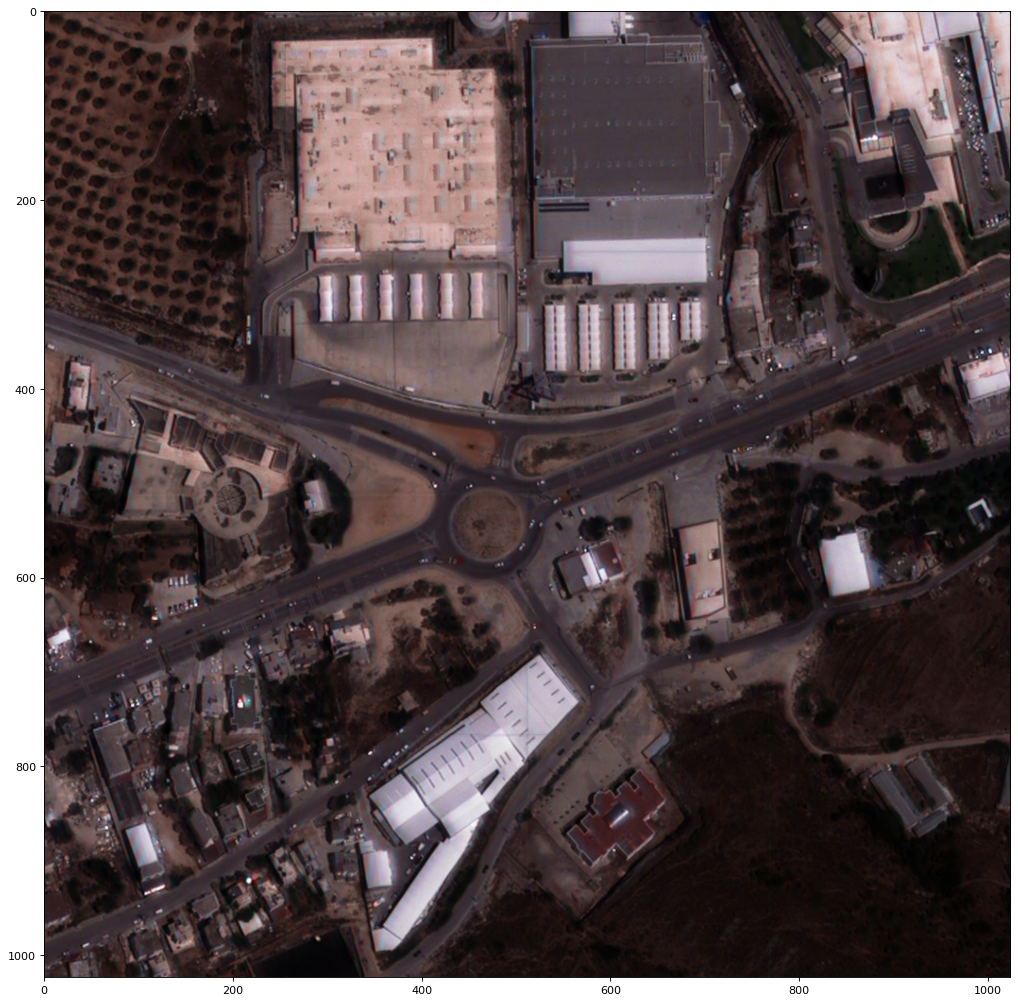

In [10]:
show_image(out.transpose(1,2,0))